In [1]:
# conda env top_bottom_moseq_37

In [6]:
import numpy as np, sys, os, tqdm, time, pickle, cv2, joblib
import matplotlib.pyplot as plt
from top_bottom_moseq.util import *
from top_bottom_moseq.io import videoReader
from glob import glob
from os.path import join, exists
import re
import pandas as pd
from tqdm import tqdm

def vec_to_angle(v, degrees=False):
    a = np.arctan(v[:,1]/v[:,0]) + np.pi*(v[:,0]>0)
    if degrees: a = a / np.pi * 180
    return a

def angle_to_vec(a, degrees=False):
    if degrees: a = a / 180 * np.pi 
    return -np.hstack([np.cos(a)[:,None],np.sin(a)[:,None]])

def camera_project(points, camera_transform, intrinsics):
    R,t = camera_transform
    if points.shape[1]==2: points = np.hstack((points,np.zeros((points.shape[0],1))))
    return cv2.projectPoints((points-t).dot(R),(0,0,0),(0,0,0),*intrinsics)[0]

def scalars_to_cameraspace(scalars, camera_transform, intrinsics):
    centroid = camera_project(scalars[:,:2], camera_transform, intrinsics)[:,0,:]
    head = camera_project(scalars[:,:2] + angle_to_vec(scalars[:,2]), camera_transform, intrinsics)[:,0,:]
    angle = vec_to_angle(head-centroid)
    return np.hstack((centroid, angle[:,None], scalars[:,3][:,None]))


def get_calibration_file(calibration_dir, date=None, date_regexp=None, current_prefix=None):
    """ Find calibration file corresponding to given date, or via regexp + prefix.
    """
    if date is not None:
        cf = glob(join(calibration_dir, date, 'camera_3D_transforms.p'))
    else:    
        regexp = re.match(date_from_folder_regexp, prefix)
        cf = glob(join(calibration_dir, regexp.group('date'), 'camera_3D_transforms.p'))
    
    if len(cf) == 0:
        print(f'No calibn file found for {prefix}, continuing...')
    elif len(cf) > 1:
        print('Found two calibration files for {prefix}, skipping for now...')
    else:
        cf = cf[0]
    return cf


In [2]:
calibration_dir = '/n/groups/datta/Jonah/Thermistor_only_recordings/calibrations'  # in which must be nested folders called, eg, 20221008 (YYYYMMDD)
calibration_file_names = 'camera_3D_transforms.p'  # all must have same name!
date_from_folder_regexp = re.compile('.*/(?P<mouse>gmou\d*)/(?P<date>\d{8})_gmou.*')
intrinsics_prefix = '/n/groups/datta/Jonah/gh_topbottom/intrinsics/JP_rig'
intrinsics = {name:load_intrinsics(intrinsics_prefix+'.'+name+'.json') for name in ['top','bottom']}
camera_names = ['top','bottom']

scalars_dict = {}

prefixes = glob('/n/groups/datta/Jonah/Thermistor_only_recordings/*/202210*/*.latents.npy')
prefixes = [path.split('.')[0] for path in prefixes]
prefixes

['/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221012_gmou81/20221012_gmou81',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221010_gmou81/20221010_gmou81',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221013_gmou81/20221013_gmou81',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221010_gmou78/20221010_gmou78',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221012_gmou78/20221012_gmou78',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221013_gmou78/20221013_gmou78',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221015_gmou83/20221015_gmou83',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221014_gmou83/20221014_gmou83',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221010_gmou83/20221010_gmou83',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou77/20221013_gmou77/20221013_gmou77',
 '/n/groups/datta/Jonah/Thermistor_only_recordings/gmou77/20221015_gmou77/202210

## Centroid / heading / something else?

In [7]:
for prefix in prefixes:
    print(prefix)
    scalars_dict[prefix] = {}
    
    # Load moseq data
    thetas = np.load(prefix+'.thetas.npy').squeeze()
    crop_origins = np.load(prefix+'.crop_centers.npy')
    
    # Load camera data
    if any([d in prefix for d in ['20221010', '20221012']]):
        cf = get_calibration_file(calibration_dir, date='20221010')
    else:
        cf = get_calibration_file(calibration_dir, date_regexp=date_from_folder_regexp, current_prefix=prefix)

    camera_transforms = pickle.load(open(cf,'rb'))
    
    # Scalars are (x, y, heading, ?)
    scalars = np.hstack([crop_origins - thetas[:,2:4], 
                        (vec_to_angle(thetas[:,:2])[:,None]+np.pi/2)%(2*np.pi),
                        thetas[:,4][:,None]])

    scalars2d = scalars_to_cameraspace(scalars, camera_transforms['bottom'], intrinsics['bottom'])
    vel = np.vstack([np.array([np.nan, np.nan]), np.diff(scalars2d[:, :2], axis=0)])
    speed = np.sqrt(np.sum(vel**2, axis=1))
    np.save(prefix+'.scalars.npy', scalars)
    np.save(prefix+'.scalars2d.npy', scalars2d)
    
    scalars_dict[prefix]['centroid_x'] = scalars2d[:, 0]
    scalars_dict[prefix]['centroid_y'] = scalars2d[:, 1]
    scalars_dict[prefix]['velocity_x'] = vel[:,0]
    scalars_dict[prefix]['velocity_y'] = vel[:,1]                     
    scalars_dict[prefix]['speed'] = speed
    scalars_dict[prefix]['heading'] = scalars2d[:, 2]
    scalars_dict[prefix]['depth_offset'] = scalars2d[:,3]
    

/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221012_gmou81/20221012_gmou81
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221010_gmou81/20221010_gmou81
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou81/20221013_gmou81/20221013_gmou81
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221010_gmou78/20221010_gmou78
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221012_gmou78/20221012_gmou78
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou78/20221013_gmou78/20221013_gmou78
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221015_gmou83/20221015_gmou83
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221014_gmou83/20221014_gmou83
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou83/20221010_gmou83/20221010_gmou83
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou77/20221013_gmou77/20221013_gmou77
/n/groups/datta/Jonah/Thermistor_only_recordings/gmou77/20221015_gmou77/20221015_gmou77
/n/groups/datta/Jonah/Thermistor

## Quickly append rough guess of mouse depth

(~1 min per video)

In [8]:
for prefix in tqdm(prefixes):
    depth_vid_path = prefix + '.top.depth_encoded.avi'
    nframes = count_frames(depth_vid_path)
    centroid_depths = np.zeros(nframes)
    with videoReader(depth_vid_path) as depth_vid:
        for iFrame, depth_frame in enumerate(depth_vid):
            if iFrame == 0:
                coord = (int(depth_frame.shape[0]/2), int(depth_frame.shape[1]/2))
            centroid_depths[iFrame] = depth_frame[coord[0], coord[1]]
    scalars_dict[prefix]['centroid_depth'] = centroid_depths
    

100%|█████████████████████████████████████████████████████████████████████| 13/13 [14:33<00:00, 67.17s/it]


## More thoroughly detect mouse body info + depth
(~30 min per video; I will parallelize and then it will be faster)

In [44]:
from skimage.segmentation import watershed
from skimage import measure
from skimage.draw import ellipse
from skimage.filters import unsharp_mask
import cv2
from top_bottom_moseq.io import videoWriter
from scipy.spatial.distance import euclidean
from skimage.feature import peak_local_max
import imageio
from copy import copy
from scipy import ndimage as ndi

ii = 0  # frame display counter
background_val_in_aligned_vids = 127  
edge_len = 15  # how much of each edge to clean up
snout_depth_offset = 3 #  move this far back from detected snout tip to find snout depth val (so don't hvae to deal with noise at edge)
center_maj_ax = 16
center_min_ax = 10
distance_from_center_thresh = 10  # if mouse center is greater than this distance from center of frame, ignore
scalar_labels = ['len', 'wid', 'ctr dpth', 'snt dpth', 'snt hdg']
scalar_precisions = [1, 1, 1, 1, 2]
for prefix in prefixes:
    ir_vid_path = prefix + '.top.ir_encoded.avi'
    depth_vid_path = prefix + '.top.depth_encoded.avi'
    scalars2d = np.load(prefix+'.scalars2d.npy')
    nframes = count_frames(ir_vid_path)
    body_scalars = np.zeros((nframes, 5))  # length, width, centroid depth, snout depth, snout heading
    test_vid_path = prefix + '.top.ir_body_watershed.mp4'
    
    nframes = count_frames(ir_vid_path)
    
    with videoReader(ir_vid_path) as ir_vid, videoReader(depth_vid_path) as depth_vid:
        
        # Prep video writer
#         vid_writer = imageio.get_writer(test_vid_path,
#                                     format='FFMPEG',
#                                     mode='I',
#                                     fps=30,
#                                     codec='h264')
        
        for iFrame, (ir_frame, depth_frame) in enumerate(tqdm(zip(ir_vid, depth_vid), total=nframes)):
                    
            # Remove noise at edges of encoded frames
            ir_frame[:edge_len, :] = background_val_in_aligned_vids
            ir_frame[-edge_len:, :] = background_val_in_aligned_vids
            ir_frame[:, -edge_len:] = background_val_in_aligned_vids
            ir_frame[:, :edge_len] = background_val_in_aligned_vids
            
            
            # Get mouse mask
            w = watershed(-1*ir_frame, compactness=0) # (was 0.5) starts at local minima; so to start on mouse's back, invert the image
            
            # Get region props of watershed regions
            labeled_image, count = measure.label(w, connectivity=1, return_num=True)
            props = measure.regionprops(labeled_image)
            
            # Prep mask in the center of the frame, to unify the watershed regions that comprise the mouse's body
            frame_center = int(ir_frame.shape[0]/2), int(ir_frame.shape[0]/2)
            rr,cc = ellipse(*frame_center, center_maj_ax, center_min_ax)
            touching_center_mask = np.zeros_like(ir_frame)
            touching_center_mask[rr,cc] = 1
            touching_center_mask = touching_center_mask.astype('bool')
            
            # Find regions touching the center
            center_labels = []
            for region in props:
                w_mask = (labeled_image == region.label)
                if np.any(w_mask & touching_center_mask):
                    center_labels.append(region.label)
            
            # Merge regions touching center into the full mouse body
            mouse_mask = np.zeros_like(ir_frame, dtype='uint8')
            for lab in center_labels:
                mouse_mask[labeled_image == lab] = 1
                
            # Find center of the complete mouse region
            mouse_region = measure.regionprops(mouse_mask)[0]
            mouse_center = (int(mouse_region.centroid[0]), int(mouse_region.centroid[1]))  # row, col
            
            # If mouse not centered, most common case seems because it's turning and an ROI on the side of its thigh was accidentally connected.
            # Try watershedding again via distance to background, ala https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
            if euclidean(mouse_center, frame_center) > distance_from_center_thresh:
                distance = ndi.distance_transform_edt(mouse_mask)
                coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=mouse_mask)
                mask = np.zeros(distance.shape, dtype=bool)
                mask[tuple(coords.T)] = True
                markers, _ = ndi.label(mask)
                labels = watershed(-distance, markers, mask=mouse_mask)
                tmp_props = measure.regionprops(labels)
                center_labels = []
                for region in tmp_props:
                    w_mask = (labels == region.label)
                    if np.any(w_mask & touching_center_mask):
                        center_labels.append(region.label)     
                mouse_mask = np.zeros_like(ir_frame, dtype='uint8')
                for lab in center_labels:
                    mouse_mask[labels == lab] = 1
                mouse_region = measure.regionprops(mouse_mask)[0]
                mouse_center = (int(mouse_region.centroid[0]), int(mouse_region.centroid[1]))  # row, col
                
            # Prep blank video frame
#             norm_frame = (ir_frame - ir_frame.min()) / (ir_frame.max() - ir_frame.min())
#             norm_frame = (norm_frame*255).astype('uint8')
#             out_frame = cv2.applyColorMap(norm_frame, cv2.COLORMAP_VIRIDIS)
            
            # Filter on distance from frame center.
            if euclidean(mouse_center, frame_center) < distance_from_center_thresh:
                
                # Get farthest forward posn on mouse (most likely neck or nose)
                x,y = np.where(mouse_mask)  # row, col
                fwd_idx_idx = np.argmin(x)  # take advantage of mice being aligned nose-up
                fwd_point = (x[fwd_idx_idx], y[fwd_idx_idx])
                
                # Check if there might be an additional nose region that was missed before
                # (move along mouse's center axis to try to find)
                snout_heading = np.nan
                for region in props:
                    if (labeled_image[fwd_point[0] - 5, mouse_center[1]] == region.label) and (region.area < 200):
                        mouse_mask[labeled_image == region.label] = 1
                        mouse_region = measure.regionprops(mouse_mask)[0]
                        mouse_center = (int(mouse_region.centroid[0]), int(mouse_region.centroid[1]))  # row, col
                        break
                        
                # Find mouse's nose, taking advantage of it being aligned nose-up
                x,y = np.where(mouse_mask)  # row, col
                min_x_val = np.min(x)
                snout_idx_idx = np.where(x == min_x_val)[0]  
                snout_point = (np.mean(x[snout_idx_idx]).astype('int'), np.mean(y[snout_idx_idx]).astype('int')) # take avg in case more than one point most forward

                # Calculate relative nose heading as angle of line betw snout tip and centroid
                snout_heading = np.arctan((mouse_center[1] - snout_point[1]) / (mouse_center[0] - snout_point[0]))*180/np.pi
                        
                # Store results
                body_scalars[iFrame, 0] = mouse_region.major_axis_length
                body_scalars[iFrame, 1] = mouse_region.minor_axis_length
                body_scalars[iFrame, 2] = depth_frame[mouse_center[0], mouse_center[1]]
                body_scalars[iFrame, 3] = depth_frame[snout_point[0] + snout_depth_offset, snout_point[1]]
                body_scalars[iFrame, 4] = snout_heading

                # Print data on video
#                 out_frame = cv2.line(out_frame,
#                                       (mouse_center[1], int(mouse_center[0] - mouse_region.major_axis_length/2)),
#                                       (mouse_center[1], int(mouse_center[0] + mouse_region.major_axis_length/2)),
#                                       (51,153,255),
#                                       1) 
#                 out_frame = cv2.line(out_frame,
#                                       (int(mouse_center[1] - mouse_region.minor_axis_length/2), mouse_center[0]),
#                                       (int(mouse_center[1] + mouse_region.minor_axis_length/2), mouse_center[0]),
#                                       (153,51,255),
#                                       1) 
#                 out_frame = cv2.line(out_frame,
#                                       (int(mouse_center[1]), int(mouse_center[0])),
#                                       (int(snout_point[1]), int(snout_point[0])),
#                                       (255,255,255),
#                                       1) 
#                 out_frame = cv2.circle(out_frame, snout_point[::-1], 1, (0,0,255,0.5), -1)  # -1 thickness to fill. since "row" is y axis and "col" is x, flip the points
#                 out_frame = cv2.circle(out_frame, mouse_center[::-1], 3, (0,255,0), -1)  
#                 for i, (label, val) in enumerate(zip(scalar_labels, body_scalars[iFrame,:])):
#                     out_frame = cv2.putText(out_frame, f'{label}: {val.round(scalar_precisions[i])}', (7,10+10*i), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255))
#                 out_frame = cv2.putText(out_frame, f'Fr #: {iFrame}', (7,10+10*(i+1)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255))
#                 vid_writer.append_data(cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB))
            
            # else if mouse still not in center of frame...
            else:
                    
                body_scalars[iFrame, 0] = np.nan
                body_scalars[iFrame, 1] = np.nan
                body_scalars[iFrame, 2] = np.nan
                body_scalars[iFrame, 3] = np.nan
                body_scalars[iFrame, 4] = np.nan
#                 for i, (label, val) in enumerate(zip(scalar_labels, body_scalars[iFrame,:])):
#                     out_frame = cv2.putText(out_frame, f'{label}: nan (detected rgn not centrd)', (10,10+10*i), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255))
#                 out_frame = cv2.putText(out_frame, f'Fr #: {iFrame}', (7,10+10*(i+1)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255))
#                 vid_writer.append_data(cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB))
            
                
            # Debug plotting
#             if iFrame > 340:
# #             if np.isnan(body_scalars[iFrame, 3]):
            
#                 plt.figure()
#                 im_to_show = copy(labeled_image)
#                 im_to_show[touching_center_mask] = -1
#                 plt.imshow(im_to_show)
                
#                 plt.figure()
#                 RGB_img = cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB)
#                 plt.imshow(RGB_img)
                
#                 plt.figure()
#                 plt.imshow(ir_frame)
#                 plt.scatter(*snout_point[::-1], color='r', s=40, alpha=0.5)  # since "row" is y axis and "col" is x, flip the points
#                 plt.scatter(*mouse_center[::-1], color='g', s=40, alpha=0.5)
#                 plt.title(f'Len: {body_scalars[iFrame, 0].round(1)}. Wid: {body_scalars[iFrame, 1].round(1)}. Frame: {iFrame}. Cent. ht: {body_scalars[iFrame, 2]}. Snout ht: {body_scalars[iFrame, 3]}\nVid: {prefix[-21:]}')
#                 plt.show()
                
#                 ii += 1

#     vid_writer.close()
        scalars_dict[prefix]['body_scalars'] = body_scalars
    break
    
    

  3%|█                                    | 3185/107878 [00:48<26:49, 65.04it/s]


KeyboardInterrupt: 

## Save output as df

In [ ]:
for prefix in prefixes:
    df = pd.DataFrame(scalars_dict[prefix])
    h5_path = prefix + '.scalars2d.h5'
    df.to_hdf(h5_path, 'scalars2d')
    

## Debugging cells

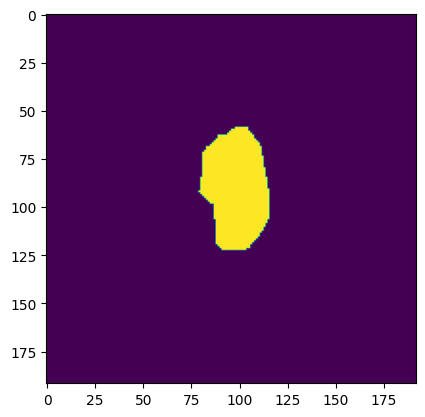

In [23]:
plt.imshow(mouse_mask)



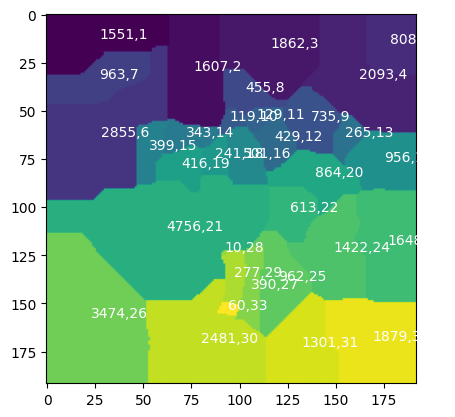

In [24]:
plt.imshow(labeled_image)
props = measure.regionprops(labeled_image)
for r in props:
    plt.text(int(r.centroid[1]), int(r.centroid[0]), f'{r.area},{r.label}', color='w')

In [25]:
for region in props:
    if (labeled_image[fwd_point[0] - 5, mouse_center[1]] == region.label) and (region.area < 200):
        mouse_mask[labeled_image == region.label] = 1
        mouse_region = measure.regionprops(mouse_mask)[0]
        mouse_center = (int(mouse_region.centroid[0]), int(mouse_region.centroid[1]))  # row, col
        print(region.label)

10


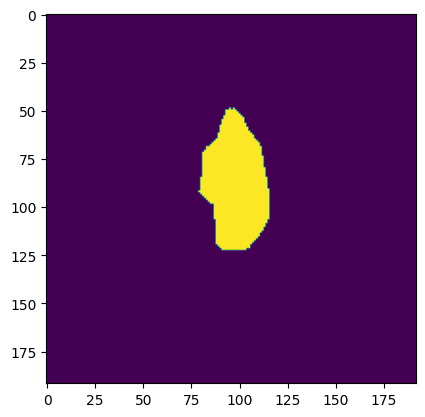

In [26]:
plt.imshow(mouse_mask)